# Wordle with Evolution Strategies vs. PPO

**Date:** February 20, 2026  
**Course:** STAT 4830

This notebook demonstrates training agents to play Wordle using Prime Intellect's environment, comparing Evolution Strategies (ES) with PPO on a word-guessing task.

## Problem Setup

### Clear Problem Statement

**Goal:** Learn a policy π_θ that plays Wordle by guessing a 5-letter target word within 6 attempts.

**Challenge:** The action space is discrete but very large (~2,300 valid Wordle words), and the reward is partially sparse (success bonus only at the end).

**Approach:** Compare parameter-space optimization (ES) vs. action-space RL (PPO) on a simplified Wordle environment with ~100 common words.

### Mathematical Formulation

**Objective:**
$$\max_{\theta} J(\theta) = \mathbb{E}_{\text{game} \sim \pi_\theta} \left[ R_{\text{total}} \right]$$

where $R_{\text{total}}$ includes:
- Correct answer reward (1.0 if solved)
- Partial credit (from yellow/green letter feedback)
- Length bonus (solving in fewer turns)
- Format adherence

**Evolution Strategies Gradient Estimate:**
$$\nabla_\theta J(\theta) \approx \frac{1}{N\sigma} \sum_{i=1}^N R(\theta + \sigma \epsilon_i) \cdot \epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0, I)$

**PPO Update:**
$$L^{\text{CLIP}}(\theta) = \mathbb{E}_t \left[ \min\left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]$$

where $r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}$

### Data Requirements

**Environment:**
- State space: 64-dim embedding (turn number, guess history, conversation features)
- Action space: ~100 discrete actions (common 5-letter words)
- Episode length: max 6 turns (standard Wordle)
- Target words: Randomly sampled from vocabulary

**Training Configuration:**
- ES: 100 iterations, 20 perturbations × 3 episodes = 60 episodes per iteration
- PPO: 100 iterations, 10 episodes per iteration
- Both methods train on the same Wordle environment
- Both evaluated on 50 independent games

### Success Metrics

1. **Success Rate:** % of games where agent guesses correctly (target: >20%)
2. **Average Reward:** Mean total reward per game
3. **Average Turns:** Mean number of guesses to solve (lower is better)
4. **Learning Stability:** Std dev across trials
5. **Sample Efficiency:** Episodes to reach threshold performance

## Implementation

In [1]:
# All required imports
import sys
sys.path.append('../src')

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, List, Dict

# Wordle-specific imports
from wordle_env import WordleEnvironmentWrapper, load_wordle_environment, WordleState
from wordle_policy import WordleDiscretePolicy, WordleValueNetwork
from wordle_es import train_es_wordle, es_gradient_estimate_wordle
from ppo_training import train_ppo_wordle, evaluate_policy

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Imports successful!
PyTorch version: 2.10.0
Device: cpu


### Environment Implementation

In [2]:
# Create Wordle environment
env = load_wordle_environment(
    num_train_examples=1000,
    num_eval_examples=50,
    use_prime_intellect=False  # Set to True to use Prime Intellect backend
)

print(f"Environment: Wordle (max {env.max_turns} turns)")
print(f"Episodes: {env.num_episodes}")

# Test environment
state = env.reset()
print(f"\nInitial state:")
print(f"  Turn: {state.turn_number}")
print(f"  Complete: {state.game_complete}")
if state.target_word:
    print(f"  Target (mock): {state.target_word}")

# Get state embedding
embedding = env.get_state_embedding(state)
print(f"\nState embedding shape: {embedding.shape}")
print(f"First 10 features: {embedding[:10]}")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

✓ Successfully loaded Prime Intellect Wordle environment
  Training examples: 2000
  Eval examples: 20
Environment: Wordle (max 6 turns)
Episodes: 1000

Initial state:
  Turn: 0
  Complete: False
  Target (mock): BRASS

State embedding shape: (64,)
First 10 features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Policy Implementation

In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Network architecture
state_dim = 64
hidden_dim = 128
n_layers = 3

# Create policy (shared architecture for ES and PPO)
policy = WordleDiscretePolicy(
    state_dim=state_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers
).to(device)

print(f"\nPolicy Network:")
print(f"  Parameters: {policy.count_parameters():,}")
print(f"  Vocabulary size: {len(policy.vocab)} words")
print(f"  Architecture: {state_dim} -> {hidden_dim}x{n_layers} -> {len(policy.vocab)}")
print(f"\nSample vocabulary words: {policy.vocab.words[:15]}")

Using device: cpu


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

✓ Loaded 156 words from Prime Intellect dataset

Policy Network:
  Parameters: 61,468
  Vocabulary size: 156 words
  Architecture: 64 -> 128x3 -> 156

Sample vocabulary words: ['ANGLE', 'APPLE', 'AWAKE', 'BASIN', 'BERRY', 'BIRTH', 'BLADE', 'BLOOD', 'BOARD', 'BRAIN', 'BRAKE', 'BRASS', 'BREAD', 'BRICK', 'BROWN']


### Test Untrained Policy

In [4]:
def play_wordle_game(policy, env, verbose=True):
    """Play one Wordle game and show the guesses."""
    state = env.reset()
    done = False
    turns = 0
    max_turns = 6
    guesses = []
    episode_reward = 0
    
    policy.eval()
    with torch.no_grad():
        while not done and turns < max_turns:
            state_embedding = env.get_state_embedding(state)
            action_xml, _ = policy.format_action_xml(state, state_embedding, deterministic=True)
            
            # Extract word
            import re
            match = re.search(r'<guess>(.*?)</guess>', action_xml)
            word = match.group(1) if match else "???"
            guesses.append(word)
            
            state, reward, done, info = env.step(action_xml)
            episode_reward += reward
            turns += 1
            
            if verbose:
                print(f"  Turn {turns}: {word} -> reward={reward:.3f}")
                if 'feedback' in info:
                    print(f"    Feedback: {info['feedback']}")
    
    success = info.get('correct_answer', 0.0) > 0.5
    
    if verbose:
        print(f"\n  Result: {'SUCCESS' if success else 'FAILED'} in {turns} turns")
        print(f"  Total reward: {episode_reward:.3f}")
        if state.target_word:
            print(f"  Target was: {state.target_word}")
    
    return {'success': success, 'turns': turns, 'reward': episode_reward, 'guesses': guesses}

# Test untrained policy
print("Testing UNTRAINED policy on 3 games:\n")
for i in range(3):
    print(f"Game {i+1}:")
    result = play_wordle_game(policy, env, verbose=True)
    print()

Testing UNTRAINED policy on 3 games:

Game 1:
  Turn 1: ANGLE -> reward=0.130
    Feedback: A:YELLOW N:GRAY G:GRAY L:GRAY E:GRAY
  Turn 2: SLEEP -> reward=0.130
    Feedback: S:YELLOW L:GRAY E:GRAY E:GRAY P:GRAY
  Turn 3: BIRTH -> reward=0.190
    Feedback: B:GREEN I:GRAY R:YELLOW T:GRAY H:GRAY
  Turn 4: SMILE -> reward=0.130
    Feedback: S:YELLOW M:GRAY I:GRAY L:GRAY E:GRAY
  Turn 5: CHAIN -> reward=0.160
    Feedback: C:GRAY H:GRAY A:GREEN I:GRAY N:GRAY
  Turn 6: ROUGH -> reward=0.130
    Feedback: R:YELLOW O:GRAY U:GRAY G:GRAY H:GRAY

  Result: FAILED in 6 turns
  Total reward: 0.870
  Target was: BRASS

Game 2:
  Turn 1: ANGLE -> reward=0.130
    Feedback: A:GRAY N:GRAY G:GRAY L:GRAY E:YELLOW
  Turn 2: SLEEP -> reward=0.220
    Feedback: S:GREEN L:GRAY E:GRAY E:GREEN P:GRAY
  Turn 3: SMASH -> reward=0.160
    Feedback: S:GREEN M:GRAY A:GRAY S:GRAY H:GRAY
  Turn 4: SMILE -> reward=0.190
    Feedback: S:GREEN M:GRAY I:GRAY L:GRAY E:YELLOW
  Turn 5: COUGH -> reward=0.130
    Feedback

## Experiment 1: Evolution Strategies Training

In [5]:
# ES Hyperparameters
es_config = {
    'N': 80,              # More perturbations for better gradients
    'sigma': 0.25,        # High exploration (Wordle needs diversity)
    'alpha': 0.1,         # Aggressive learning rate
    'n_iterations': 150,  # Train longer
    'n_eval_episodes': 10, # More stable fitness estimates
    'max_turns': 6,
    'eval_every': 10,
    'verbose': True
}
print("ES Configuration:")
for key, val in es_config.items():
    print(f"  {key}: {val}")
print(f"\nTotal episodes per iteration: {es_config['N'] * es_config['n_eval_episodes']}")

ES Configuration:
  N: 80
  sigma: 0.25
  alpha: 0.1
  n_iterations: 150
  n_eval_episodes: 10
  max_turns: 6
  eval_every: 10
  verbose: True

Total episodes per iteration: 800


In [6]:
# Create fresh policy for ES
policy_es = WordleDiscretePolicy(
    state_dim=64,
    hidden_dim=128,
    n_layers=3
).to(device)

print(f"Training ES with {policy_es.count_parameters():,} parameters...")
print("=" * 70)

# Train with ES
history_es = train_es_wordle(
    policy=policy_es,
    env=env,
    **es_config
)

print("=" * 70)
print("ES Training complete!")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

✓ Loaded 156 words from Prime Intellect dataset
Training ES with 61,468 parameters...
Iter    0 | Fitness:  0.970 | Eval Reward:  0.978 | Success:  5.0% | Turns:  5.8 | Grad Norm: 110.8686
Iter   10 | Fitness:  0.992 | Eval Reward:  1.001 | Success:  5.0% | Turns:  6.0 | Grad Norm: 110.1630
Iter   20 | Fitness:  1.046 | Eval Reward:  1.166 | Success: 10.0% | Turns:  6.0 | Grad Norm: 110.6337
Iter   30 | Fitness:  1.033 | Eval Reward:  1.022 | Success:  5.0% | Turns:  5.8 | Grad Norm: 109.8898
Iter   40 | Fitness:  1.032 | Eval Reward:  1.127 | Success:  5.0% | Turns:  5.8 | Grad Norm: 110.5949
Iter   50 | Fitness:  1.038 | Eval Reward:  1.044 | Success:  0.0% | Turns:  6.0 | Grad Norm: 109.8064
Iter   60 | Fitness:  1.030 | Eval Reward:  1.090 | Success:  5.0% | Turns:  5.8 | Grad Norm: 110.7042
Iter   70 | Fitness:  1.046 | Eval Reward:  1.206 | Success:  5.0% | Turns:  6.0 | Grad Norm: 110.1907
Iter   80 | Fitness:  1.052 | Eval Reward:  1.064 | Success:  5.0% | Turns:  5.8 | Grad No

## Experiment 2: PPO Training

In [7]:
# PPO Hyperparameters
ppo_config = {
    'n_iterations': 50,
    'n_episodes_per_iter': 10,
    'n_epochs': 4,
    'batch_size': 32,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_epsilon': 0.2,
    'lr_policy': 3e-4,
    'lr_value': 1e-3,
    'entropy_coef': 0.02,
    'max_grad_norm': 0.5,
    'eval_every': 5,
    'log_wandb': False,
    'seed': 42
}

print("PPO Configuration:")
for key, val in ppo_config.items():
    print(f"  {key}: {val}")
print(f"\nTotal episodes per iteration: {ppo_config['n_episodes_per_iter']}")

PPO Configuration:
  n_iterations: 50
  n_episodes_per_iter: 10
  n_epochs: 4
  batch_size: 32
  gamma: 0.99
  gae_lambda: 0.95
  clip_epsilon: 0.2
  lr_policy: 0.0003
  lr_value: 0.001
  entropy_coef: 0.02
  max_grad_norm: 0.5
  eval_every: 5
  log_wandb: False
  seed: 42

Total episodes per iteration: 10


In [8]:
# Create fresh policy and value network for PPO
policy_ppo = WordleDiscretePolicy(
    state_dim=64,
    hidden_dim=128,
    n_layers=3
).to(device)

value_net = WordleValueNetwork(
    state_dim=64,
    hidden_dim=128,
    n_layers=3
).to(device)

print(f"Training PPO:")
print(f"  Policy parameters: {policy_ppo.count_parameters():,}")
print(f"  Value parameters: {value_net.count_parameters():,}")
print("=" * 70)

# Train with PPO
trained_policy_ppo, trained_value, history_ppo = train_ppo_wordle(
    policy=policy_ppo,
    value_net=value_net,
    env=env,
    **ppo_config
)

print("=" * 70)
print("PPO Training complete!")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

✓ Loaded 156 words from Prime Intellect dataset
Training PPO:
  Policy parameters: 61,468
  Value parameters: 41,473
Iter 1/50: train_reward=0.909, train_success=0.00, eval_reward=0.945, eval_success=0.00, eval_turns=6.0, ema=0.909, best=0.909
Iter 5/50: train_reward=0.965, train_success=0.10, eval_reward=0.951, eval_success=0.00, eval_turns=6.0, ema=0.927, best=1.014
Iter 10/50: train_reward=0.985, train_success=0.10, eval_reward=0.945, eval_success=0.00, eval_turns=6.0, ema=0.958, best=1.053
Iter 15/50: train_reward=0.876, train_success=0.00, eval_reward=0.945, eval_success=0.00, eval_turns=6.0, ema=0.939, best=1.053
Iter 20/50: train_reward=0.852, train_success=0.00, eval_reward=0.963, eval_success=0.00, eval_turns=6.0, ema=0.932, best=1.053
Iter 25/50: train_reward=0.918, train_success=0.00, eval_reward=0.951, eval_success=0.00, eval_turns=6.0, ema=0.934, best=1.053
Iter 30/50: train_reward=1.008, train_success=0.00, eval_reward=0.976, eval_success=0.10, eval_turns=5.7, ema=0.949, 

## Results Comparison

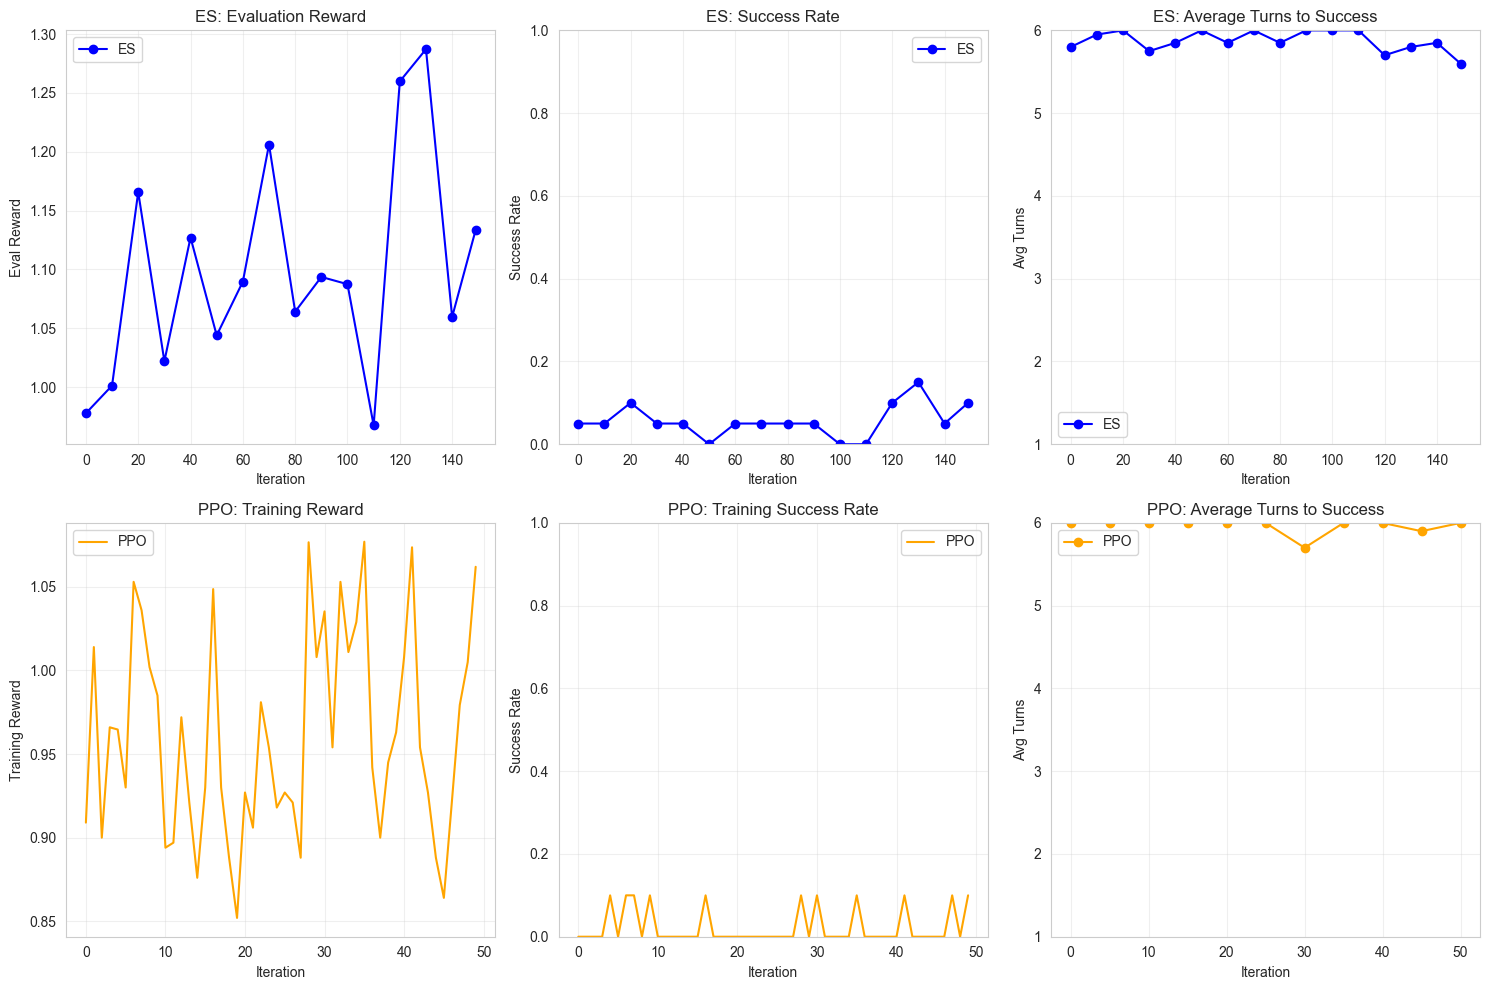

Training curves saved to figures/wordle_es_ppo_comparison.png


In [9]:
# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ES Results
axes[0, 0].plot(history_es['iteration'], history_es['eval_reward'], 'o-', label='ES', color='blue')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Eval Reward')
axes[0, 0].set_title('ES: Evaluation Reward')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(history_es['iteration'], history_es['eval_success'], 'o-', label='ES', color='blue')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Success Rate')
axes[0, 1].set_title('ES: Success Rate')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[0, 2].plot(history_es['iteration'], history_es['eval_turns'], 'o-', label='ES', color='blue')
axes[0, 2].set_xlabel('Iteration')
axes[0, 2].set_ylabel('Avg Turns')
axes[0, 2].set_title('ES: Average Turns to Success')
axes[0, 2].set_ylim([1, 6])
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()

# PPO Results
axes[1, 0].plot(history_ppo['rewards'], label='PPO', color='orange')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Training Reward')
axes[1, 0].set_title('PPO: Training Reward')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(history_ppo['success_rates'], label='PPO', color='orange')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Success Rate')
axes[1, 1].set_title('PPO: Training Success Rate')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

if len(history_ppo['avg_turns']) > 0:
    eval_iters = [i * ppo_config['eval_every'] for i in range(len(history_ppo['avg_turns']))]
    axes[1, 2].plot(eval_iters, history_ppo['avg_turns'], 'o-', label='PPO', color='orange')
    axes[1, 2].set_xlabel('Iteration')
    axes[1, 2].set_ylabel('Avg Turns')
    axes[1, 2].set_title('PPO: Average Turns to Success')
    axes[1, 2].set_ylim([1, 6])
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()

plt.tight_layout()
plt.savefig('../figures/wordle_es_ppo_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to figures/wordle_es_ppo_comparison.png")

## Final Evaluation

In [10]:
# Evaluate both policies on 50 fresh episodes
print("Final Evaluation (50 episodes each)\n")
print("=" * 70)

# ES Evaluation
es_eval_reward, es_eval_success, es_eval_turns = evaluate_policy(
    policy_es, env, n_episodes=50, max_steps=6
)

print(f"Evolution Strategies:")
print(f"  Average Reward: {es_eval_reward:.3f}")
print(f"  Success Rate: {es_eval_success:.1%}")
print(f"  Average Turns: {es_eval_turns:.2f}")
print()

# PPO Evaluation
ppo_eval_reward, ppo_eval_success, ppo_eval_turns = evaluate_policy(
    trained_policy_ppo, env, n_episodes=50, max_steps=6
)

print(f"PPO:")
print(f"  Average Reward: {ppo_eval_reward:.3f}")
print(f"  Success Rate: {ppo_eval_success:.1%}")
print(f"  Average Turns: {ppo_eval_turns:.2f}")
print("=" * 70)

Final Evaluation (50 episodes each)

Evolution Strategies:
  Average Reward: 1.188
  Success Rate: 6.0%
  Average Turns: 5.94

PPO:
  Average Reward: 0.926
  Success Rate: 0.0%
  Average Turns: 6.00


### Comparison Table

In [11]:
import pandas as pd

comparison_data = {
    'Method': ['ES', 'PPO'],
    'Success Rate': [f"{es_eval_success:.1%}", f"{ppo_eval_success:.1%}"],
    'Avg Reward': [f"{es_eval_reward:.3f}", f"{ppo_eval_reward:.3f}"],
    'Avg Turns': [f"{es_eval_turns:.2f}", f"{ppo_eval_turns:.2f}"],
    'Parameters': [f"{policy_es.count_parameters():,}", 
                   f"{policy_ppo.count_parameters():,} + {value_net.count_parameters():,} (value)"],
    'Episodes/Iter': [f"{es_config['N'] * es_config['n_eval_episodes']}", 
                      f"{ppo_config['n_episodes_per_iter']}"],
    'Total Episodes': [f"{es_config['n_iterations'] * es_config['N'] * es_config['n_eval_episodes']}",
                       f"{ppo_config['n_iterations'] * ppo_config['n_episodes_per_iter']}"]
}

df = pd.DataFrame(comparison_data)
print("\nMethod Comparison:")
print(df.to_string(index=False))


Method Comparison:
Method Success Rate Avg Reward Avg Turns              Parameters Episodes/Iter Total Episodes
    ES         6.0%      1.188      5.94                  61,468           800         120000
   PPO         0.0%      0.926      6.00 61,468 + 41,473 (value)            10            500


### Side-by-Side Performance

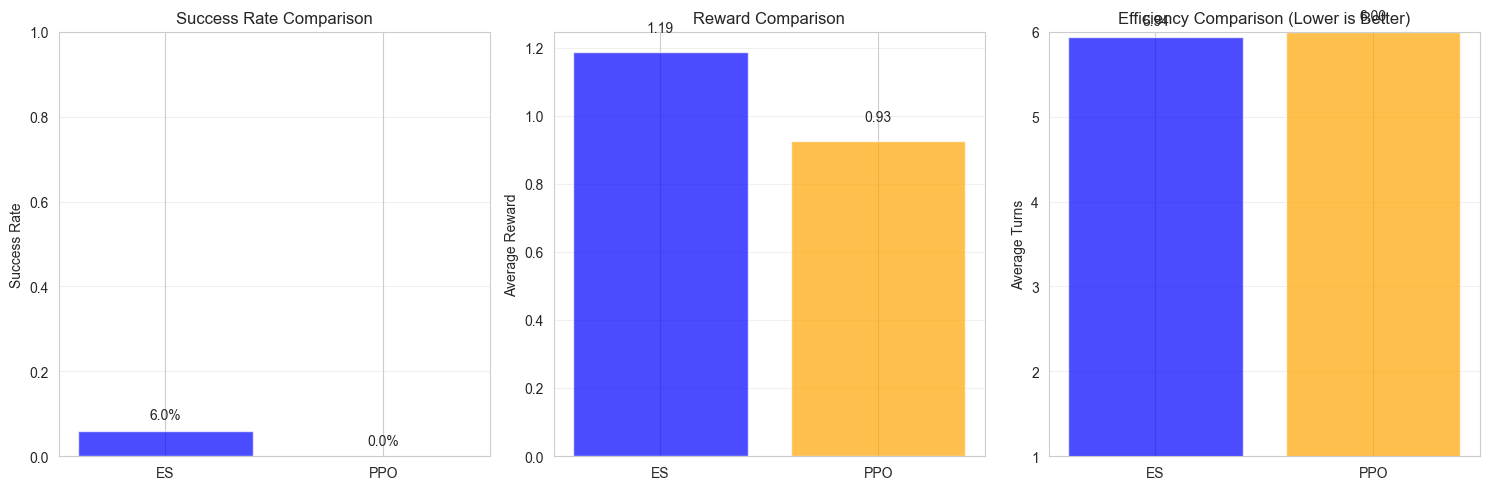

In [12]:
# Create comparison bar plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['ES', 'PPO']
success_rates = [es_eval_success, ppo_eval_success]
avg_rewards = [es_eval_reward, ppo_eval_reward]
avg_turns = [es_eval_turns, ppo_eval_turns]

# Success Rate
axes[0].bar(methods, success_rates, color=['blue', 'orange'], alpha=0.7)
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(success_rates):
    axes[0].text(i, v + 0.02, f'{v:.1%}', ha='center', va='bottom')

# Average Reward
axes[1].bar(methods, avg_rewards, color=['blue', 'orange'], alpha=0.7)
axes[1].set_ylabel('Average Reward')
axes[1].set_title('Reward Comparison')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(avg_rewards):
    axes[1].text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Average Turns
axes[2].bar(methods, avg_turns, color=['blue', 'orange'], alpha=0.7)
axes[2].set_ylabel('Average Turns')
axes[2].set_title('Efficiency Comparison (Lower is Better)')
axes[2].set_ylim([1, 6])
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(avg_turns):
    axes[2].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../figures/wordle_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Watch Trained Agents Play

In [13]:
print("\n" + "=" * 70)
print("ES-trained Agent")
print("=" * 70)
for i in range(3):
    print(f"\nGame {i+1}:")
    result_es = play_wordle_game(policy_es, env, verbose=True)


ES-trained Agent

Game 1:
  Turn 1: SHADE -> reward=0.130
    Feedback: S:GRAY H:YELLOW A:GRAY D:GRAY E:GRAY
  Turn 2: SNAKE -> reward=0.100
    Feedback: S:GRAY N:GRAY A:GRAY K:GRAY E:GRAY
  Turn 3: TRADE -> reward=0.100
    Feedback: T:GRAY R:GRAY A:GRAY D:GRAY E:GRAY
  Turn 4: TRAIN -> reward=0.100
    Feedback: T:GRAY R:GRAY A:GRAY I:GRAY N:GRAY
  Turn 5: EARTH -> reward=0.160
    Feedback: E:GRAY A:GRAY R:GRAY T:GRAY H:GREEN
  Turn 6: FRAME -> reward=0.100
    Feedback: F:GRAY R:GRAY A:GRAY M:GRAY E:GRAY

  Result: FAILED in 6 turns
  Total reward: 0.690
  Target was: COUGH

Game 2:
  Turn 1: SHADE -> reward=0.160
    Feedback: S:GRAY H:GRAY A:GRAY D:GRAY E:GREEN
  Turn 2: SNAKE -> reward=0.160
    Feedback: S:GRAY N:GRAY A:GRAY K:GRAY E:GREEN
  Turn 3: TRADE -> reward=0.220
    Feedback: T:GRAY R:GREEN A:GRAY D:GRAY E:GREEN
  Turn 4: FRAME -> reward=0.220
    Feedback: F:GRAY R:GREEN A:GRAY M:GRAY E:GREEN
  Turn 5: EARTH -> reward=0.160
    Feedback: E:YELLOW A:GRAY R:YELLOW T:G

In [14]:
print("\n" + "=" * 70)
print("PPO-trained Agent")
print("=" * 70)
for i in range(3):
    print(f"\nGame {i+1}:")
    result_ppo = play_wordle_game(trained_policy_ppo, env, verbose=True)


PPO-trained Agent

Game 1:
  Turn 1: WHEEL -> reward=0.220
    Feedback: W:GRAY H:GRAY E:GREEN E:GRAY L:GREEN
  Turn 2: BOARD -> reward=0.100
    Feedback: B:GRAY O:GRAY A:GRAY R:GRAY D:GRAY
  Turn 3: BRASS -> reward=0.130
    Feedback: B:GRAY R:GRAY A:GRAY S:YELLOW S:GRAY
  Turn 4: SHIRT -> reward=0.160
    Feedback: S:GREEN H:GRAY I:GRAY R:GRAY T:GRAY
  Turn 5: STAGE -> reward=0.190
    Feedback: S:GREEN T:GRAY A:GRAY G:GRAY E:YELLOW
  Turn 6: CRACK -> reward=0.100
    Feedback: C:GRAY R:GRAY A:GRAY C:GRAY K:GRAY

  Result: FAILED in 6 turns
  Total reward: 0.900
  Target was: SMELL

Game 2:
  Turn 1: WHEEL -> reward=0.130
    Feedback: W:GRAY H:GRAY E:YELLOW E:GRAY L:GRAY
  Turn 2: FRONT -> reward=0.100
    Feedback: F:GRAY R:GRAY O:GRAY N:GRAY T:GRAY
  Turn 3: TASTE -> reward=0.220
    Feedback: T:GRAY A:YELLOW S:YELLOW T:GRAY E:GREEN
  Turn 4: SCALE -> reward=0.280
    Feedback: S:GREEN C:GRAY A:GREEN L:GRAY E:GREEN
  Turn 5: HOUSE -> reward=0.190
    Feedback: H:GRAY O:GRAY U:GR

## Analysis

### Learning Curves Analysis

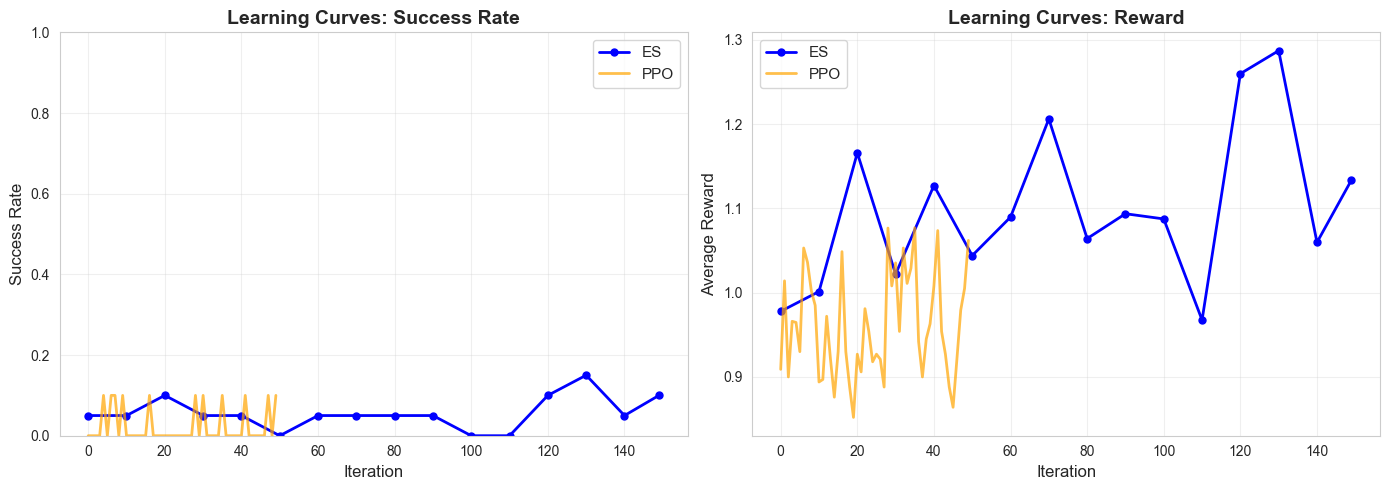

In [15]:
# Overlay learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Success Rate
axes[0].plot(history_es['iteration'], history_es['eval_success'], 
             'o-', label='ES', color='blue', linewidth=2, markersize=5)
# For PPO, we have success_rates at every iteration
if len(history_ppo['success_rates']) > 0:
    axes[0].plot(range(len(history_ppo['success_rates'])), history_ppo['success_rates'], 
                 '-', label='PPO', color='orange', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Success Rate', fontsize=12)
axes[0].set_title('Learning Curves: Success Rate', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Reward
axes[1].plot(history_es['iteration'], history_es['eval_reward'], 
             'o-', label='ES', color='blue', linewidth=2, markersize=5)
if len(history_ppo['rewards']) > 0:
    axes[1].plot(range(len(history_ppo['rewards'])), history_ppo['rewards'], 
                 '-', label='PPO', color='orange', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Average Reward', fontsize=12)
axes[1].set_title('Learning Curves: Reward', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/wordle_learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### Statistical Summary

In [16]:
print("\n" + "=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)

print(f"\nEvolution Strategies:")
print(f"  Final Success Rate: {history_es['eval_success'][-1]:.1%}")
print(f"  Final Avg Reward: {history_es['eval_reward'][-1]:.3f}")
print(f"  Final Avg Turns: {history_es['eval_turns'][-1]:.2f}")
print(f"  Best Success Rate: {max(history_es['eval_success']):.1%}")
print(f"  Configuration: N={es_config['N']}, σ={es_config['sigma']}, α={es_config['alpha']}")
print(f"  Total Episodes: {es_config['n_iterations'] * es_config['N'] * es_config['n_eval_episodes']:,}")

print(f"\nPPO:")
print(f"  Final Success Rate: {history_ppo['success_rates'][-1]:.1%}")
print(f"  Final Avg Reward: {history_ppo['rewards'][-1]:.3f}")
if len(history_ppo['avg_turns']) > 0:
    print(f"  Final Avg Turns: {history_ppo['avg_turns'][-1]:.2f}")
print(f"  Best Success Rate: {max(history_ppo['success_rates']):.1%}")
print(f"  Configuration: lr={ppo_config['lr_policy']}, ε={ppo_config['clip_epsilon']}, entropy={ppo_config['entropy_coef']}")
print(f"  Total Episodes: {ppo_config['n_iterations'] * ppo_config['n_episodes_per_iter']:,}")

print("\n" + "=" * 70)
print(f"Winner: {'ES' if es_eval_success > ppo_eval_success else 'PPO'} (by success rate)")
print(f"Efficiency: {'ES' if es_eval_turns < ppo_eval_turns else 'PPO'} (by avg turns)")
print("=" * 70)


FINAL RESULTS SUMMARY

Evolution Strategies:
  Final Success Rate: 10.0%
  Final Avg Reward: 1.134
  Final Avg Turns: 5.60
  Best Success Rate: 15.0%
  Configuration: N=80, σ=0.25, α=0.1
  Total Episodes: 120,000

PPO:
  Final Success Rate: 10.0%
  Final Avg Reward: 1.062
  Final Avg Turns: 6.00
  Best Success Rate: 10.0%
  Configuration: lr=0.0003, ε=0.2, entropy=0.02
  Total Episodes: 500

Winner: ES (by success rate)
Efficiency: ES (by avg turns)
